# Кредитный скоринг
## Задача:  
    Необходимо решить задачу кредитного скоринга клиентов Альфа-Банка, используя только данные кредитных историй.

# Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
from enum import Enum

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

from category_encoders.count import CountEncoder as ce_CountEncoder
from category_encoders.one_hot import OneHotEncoder as ce_OneHotEncoder
from category_encoders.woe import WOEEncoder as ce_WOEEncoder
from category_encoders.target_encoder import TargetEncoder as ce_TargetEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

from sklearn.cluster import KMeans

from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import AllKNN
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import InstanceHardnessThreshold

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import ADASYN


RANDOM_SEED = 100
TEST_SIZE = 0.3

# Загрузка данных

**Описание полей**

- id - Идентификатор заявки. Заявки пронумерованы так, что большему номеру соответствует более поздняя дата заявки.
- rn - Порядковый номер кредитного продукта в кредитной истории. Большему номеру соответствует продукт с более поздней датой открытия.
- pre_since_opened - Дней с даты открытия кредита до даты сбора данных (бинаризовано*)
- pre_since_confirmed - Дней с даты подтверждения информации по кредиту до даты сбора данных (бинаризовано*)
- pre_pterm - Плановое количество дней с даты открытия кредита до даты закрытия (бинаризовано*)
- pre_fterm	- Фактическое количество дней с даты открытия кредита до даты закрытия (бинаризовано*)
- pre_till_pclose - Плановое количество дней с даты сбора данных до даты закрытия кредита (бинаризовано*)
- pre_till_fclose - Фактическое количество дней с даты сбора данных до даты закрытия кредита (бинаризовано*)
- pre_loans_credit_limit - Кредитный лимит (бинаризовано*)
- pre_loans_next_pay_summ - Сумма следующего платежа по кредиту (бинаризовано*)
- pre_loans_outstanding - Оставшаяся невыплаченная сумма кредита (бинаризовано*)
- pre_loans_total_overdue - Текущая просроченная задолженность (бинаризовано*)
- pre_loans_max_overdue_sum - Максимальная просроченная задолженность (бинаризовано*)
- pre_loans_credit_cost_rate - Полная стоимость кредита (бинаризовано*)
- pre_loans5 - Число просрочек до 5 дней (бинаризовано*)
- pre_loans530 - Число просрочек от 5 до 30 дней (бинаризовано*)
- pre_loans3060 - Число просрочек от 30 до 60 дней (бинаризовано*)
- pre_loans6090 - Число просрочек от 60 до 90 дней (бинаризовано*)
- pre_loans90 - Число просрочек более, чем на 90 дней (бинаризовано*)
- is_zero_loans_5 - Флаг: нет просрочек до 5 дней
- is_zero_loans_530 - Флаг: нет просрочек от 5 до 30 дней
- is_zero_loans_3060 - Флаг: нет просрочек от 30 до 60 дней
- is_zero_loans_6090 - Флаг: нет просрочек от 60 до 90 дней
- is_zero_loans90 - Флаг: нет просрочек более, чем на 90 дней
- pre_util - Отношение оставшейся невыплаченной суммы кредита к кредитному лимиту (бинаризовано*)
- pre_over2limit - Отношение текущей просроченной задолженности к кредитному лимиту (бинаризовано*)
- pre_maxover2limit - Отношенение максимальной просроченной задолженности к кредитному лимиту (бинаризовано*)
- is_zero_util - Флаг: отношение оставшейся невыплаченной суммы кредита к кредитному лимиту равняется 0
- is_zero_over2limit - Флаг: отношение текущей просроченной задолженности к кредитному лимиту равняется 0
- is_zero_maxover2limit - Флаг: отношение максимальной просроченной задолженности к кредитному лимиту равняется 0
- enc_paym_{0..N} - Статусы ежемесячных платежей за последние N месяцев (закодировано**)
- enc_loans_account_holder_type - Тип отношения к кредиту (закодировано**)
- enc_loans_credit_status - Статус кредита (закодировано**)
- enc_loans_account_cur - Валюта кредита (закодировано**)
- enc_loans_credit_type - Тип кредита (закодировано**)
- pclose_flag - Флаг: плановое количество дней с даты открытия кредита до даты закрытия не определено 
- fclose_flag - Флаг: фактическое количество дней с даты открытия кредита до даты закрытия не определено
- flag - Целевая переменная, 1 – факт ухода в дефолт. Доступна участникам в обучающей выборке.

\* область значений поля разбивается на N непересекающихся промежутков, каждому промежутку случайным образом ставится в соответствие уникальный номер от 0 до N-1, значение поля  
\** каждому уникальному значению поля случайным образом ставится в соответствие уникальный номер от 0 до K, значение поля заменяется номером этого значения

In [3]:
def data_import(url_data, url_target_data):
    df_features = pd.read_parquet(url_data)
    df_target = pd.read_csv(url_target_data)
    df = df_features.merge(df_target[["id", "flag"]], how="outer", on="id")
    df = df.loc[df["rn"].notnull()]
    df.rename(columns={"flag": "target"}, inplace=True)
    return df   

# Обработка данных

In [4]:
def hist_plot(x, y):
    fig, bar_axes = plt.subplots(figsize=(26,6))
    bar_axes.set_title("Диаграмма")   # Задать заголовок графика
    bar_axes.set_ylabel("y_label")          # Задать зоголовок для оси y
    bar_axes.set_xlabel("x_label")          # Задать зоголовок для оси x
    bar1 = bar_axes.bar(x, y, 0.55, label="Column")
    bar_axes.set_xticks(x)
    bar_axes.bar_label(bar1, padding=3)
    bar_axes.legend()          # Включить наименование графиков
    plt.show()

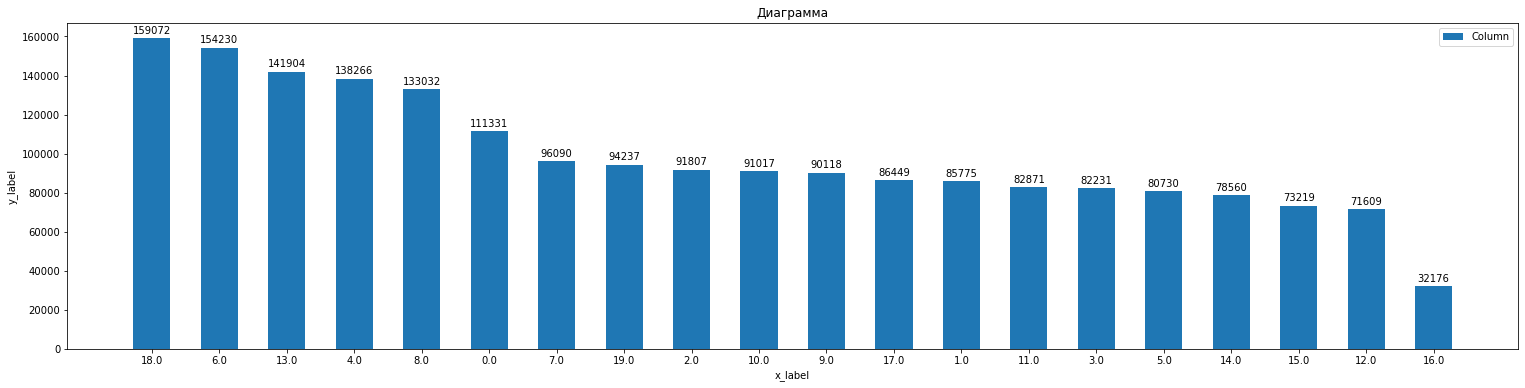

In [13]:
hist_plot(plot_df["id"], plot_df["pre_since_opened"])

## Кодирование категориальных признаков

### Frequency Encoding

#### Функция

In [5]:
def frequency_encoding_convert(data, all_columns = True):
    fe = {}
    
    if (all_columns == True):
        data_columns = data.columns
        
    else:
        data_columns = all_columns
               
    data[data_columns] = data[data_columns].astype("string")
    for column in data_columns:
        fe[column] = (data[column].value_counts()/len(data)).to_dict()
            
    for column in data_columns:
        data[column] = data[column].map(fe[column])
    
    return data

### One-Hot Encoding

In [6]:
def one_hot_encoding_convert(data, all_columns = True):
    ohe = OneHotEncoder()
    
    if (all_columns == True):
        data_columns = data.columns
        
    else:
        data_columns = all_columns
               
    data[data_columns] = data[data_columns].astype("string")
    
    data = ohe.fit_transform(data[data_columns])
    data = pd.DataFrame(data.todense())
    
    return data

### Mean Encoding

#### Функция

In [7]:
def mean_encoding_convert(X_data, Y_data, all_columns = True):
    me = {}
            
    if (all_columns == True):
        data_columns = X_data.columns
        
    else:
        data_columns = all_columns
               
    X_data[data_columns] = X_data[data_columns].astype("string")
    
    data = pd.concat([X_data, Y_data], axis=1, ignore_index=True)
    data.columns = X_data.columns.to_list() + [Y_data.name]
    
    for column in data_columns:
        me[column] = data.groupby([column])["target"].mean().to_dict()
            
    for column in data_columns:
        X_data[column] = X_data[column].map(me[column])
    
    return X_data

### Общая Функция

In [8]:
def encoding_convert(X_data, Y_data, X_test, type_encoding = "Frequency Encoding", all_columns = True):
    if type_encoding == "Frequency Encoding":
        fe = {}
        if (all_columns == True):
            data_columns = X_data.columns
        else:
            data_columns = all_columns
        X_data[data_columns] = X_data[data_columns].astype("string")
        for column in data_columns:
            fe[column] = (X_data[column].value_counts()/len(X_data)).to_dict()
        for column in data_columns:
            X_data[column] = X_data[column].map(fe[column])
            X_test[column] = X_test[column].map(fe[column])
            
    elif type_encoding == "One-Hot Encoding":
        ohe = OneHotEncoder()
        if (all_columns == True):
            data_columns = X_data.columns
        else:
            data_columns = all_columns
        X_data[data_columns] = X_data[data_columns].astype("string")
        X_data = ohe.fit_transform(X_data[data_columns])
        X_data = pd.DataFrame(X_data.todense())
        
        X_test = ohe.transform(X_test[data_columns])
        X_test = pd.DataFrame(X_test.todense())
        
    else:
        me = {}
        if (all_columns == True):
            data_columns = X_data.columns
        else:
            data_columns = all_columns
        X_data[data_columns] = X_data[data_columns].astype("string")
        data = pd.concat([X_data, Y_data], axis=1, ignore_index=True)
        data.columns = X_data.columns.to_list() + [Y_data.name]
        for column in data_columns:
            me[column] = data.groupby([column])["target"].mean().to_dict()
        for column in data_columns:
            X_data[column] = X_data[column].map(me[column])
            X_test[column] = X_test[column].map(me[column])
            
    return X_data, X_test

## Обработка выбросов

In [9]:
def get_outlier_boundaries(X_data, col, outlier_boundary_type = "SIGMA"):
    if outlier_boundary_type == "SIGMA":
        K1 = 3
        lower_boundary = X_data[col].mean() - (K1 * X_data[col].std())
        upper_boundary = X_data[col].mean() + (K1 * X_data[col].std())

    elif outlier_boundary_type == "QUANTILE":
        lower_boundary = X_data[col].quantile(0.05)
        upper_boundary = X_data[col].quantile(0.95)

    elif outlier_boundary_type == "IRQ":
        K2 = 1.5
        IQR = X_data[col].quantile(0.75) - X_data[col].quantile(0.25)
        lower_boundary = X_data[col].quantile(0.25) - (K2 * IQR)
        upper_boundary = X_data[col].quantile(0.75) + (K2 * IQR)

    else:
        raise NameError('Unknown Outlier Boundary Type')
        
    #X_data_outliers_temp = np.where(X_data[col] > upper_boundary, True, np.where(X_data[col] < lower_boundary, True, False))
    #X_data = X_data.loc[~(X_data_outliers_temp), ]
    
    
    
    X_data[col] = np.where(X_data[col] > upper_boundary, upper_boundary, np.where(X_data[col] < lower_boundary, lower_boundary, X_data[col]))

        
    return X_data

##  Дисбаланс выборки

In [10]:
def inbalance_convert(type_sampling, X_data, Y_data):
    if type_sampling == "RandomUnderSampler":
        randomUnderSampler = RandomUnderSampler(sampling_strategy='auto', random_state=RANDOM_SEED, replacement=True)  
        X_data, Y_data = randomUnderSampler.fit_resample(X_data, Y_data)
        
    elif type_sampling == "CondensedNearestNeighbour":
        сondensedNearestNeighbour = CondensedNearestNeighbour(sampling_strategy='auto', random_state=RANDOM_SEED, n_neighbors=1, n_jobs=-1)  
        X_data, Y_data = сondensedNearestNeighbour.fit_resample(X_data, Y_data)
        
    elif type_sampling == "TomekLinks":
        tomekLinks = TomekLinks(sampling_strategy='auto', n_jobs=-1)  
        X_data, Y_data = tomekLinks.fit_resample(X_data, Y_data)
        
    elif type_sampling == "OneSidedSelection":
        oneSidedSelection = OneSidedSelection(sampling_strategy='auto', n_neighbors=1, random_state=RANDOM_SEED, n_jobs=-1)  
        X_data, Y_data = oneSidedSelection.fit_resample(X_data, Y_data)
        
    elif type_sampling == "EditedNearestNeighbours_all":
        editedNearestNeighboursAll = EditedNearestNeighbours(sampling_strategy='auto', kind_sel='all', n_neighbors=3, n_jobs=-1)  
        X_data, Y_data = editedNearestNeighboursAll.fit_resample(X_data, Y_data)
        
    elif type_sampling == "EditedNearestNeighbours_mode":
        editedNearestNeighboursMode = EditedNearestNeighbours(sampling_strategy='auto', kind_sel='mode', n_neighbors=3, n_jobs=-1)  
        X_data, Y_data = editedNearestNeighboursMode.fit_resample(X_data, Y_data)
        
    elif type_sampling == "RepeatedEditedNearestNeighbours_all":
        editedRepeatedNearestNeighboursAll = RepeatedEditedNearestNeighbours(sampling_strategy='auto', kind_sel='all', n_neighbors=3, n_jobs=-1)  
        X_data, Y_data = editedRepeatedNearestNeighboursAll.fit_resample(X_data, Y_data)
        
    elif type_sampling == "RepeatedEditedNearestNeighbours_mode":
        editedRepeatedNearestNeighboursMode = RepeatedEditedNearestNeighbours(sampling_strategy='auto', kind_sel='mode', n_neighbors=3, n_jobs=-1)  
        X_data, Y_data = editedRepeatedNearestNeighboursMode.fit_resample(X_data, Y_data)
        
    elif type_sampling == "AllKNN_all":
        allKNNAll = AllKNN(sampling_strategy='auto', kind_sel='all', n_neighbors=3, n_jobs=-1)  
        X_data, Y_data = allKNNAll.fit_resample(X_data, Y_data)
        
    elif type_sampling == "AllKNN_mode":
        allKNNMode = AllKNN(sampling_strategy='auto', kind_sel='mode', n_neighbors=3, n_jobs=-1)  
        X_data, Y_data = allKNNMode.fit_resample(X_data, Y_data)
        
    elif type_sampling == "NeighbourhoodCleaningRule":
        neighbourhoodCleaningRule = NeighbourhoodCleaningRule(sampling_strategy='auto', n_jobs=-1)  
        X_data, Y_data = neighbourhoodCleaningRule.fit_resample(X_data, Y_data)
    elif type_sampling == "InstanceHardnessThreshold":
        iht = InstanceHardnessThreshold(estimator=RandomForestClassifier(n_estimators=100, random_state=1), sampling_strategy='auto', random_state=RANDOM_SEED, n_jobs=-1, cv=3)
        X_data, Y_data = iht.fit_resample(X_data, Y_data)
    
    
    elif type_sampling == "RandomOverSampler":
        ros = RandomOverSampler(sampling_strategy='auto', random_state=RANDOM_SEED)
        X_data, Y_data = ros.fit_resample(X_data, Y_data)
        
    elif type_sampling == "SMOTE":
        sm = SMOTE(sampling_strategy='auto', random_state=RANDOM_SEED, k_neighbors=5, n_jobs=-1)
        X_data, Y_data = sm.fit_resample(X_data, Y_data)
        
    elif type_sampling == "BorderlineSMOTE_1":
        sm_b = BorderlineSMOTE(sampling_strategy='auto', random_state=RANDOM_SEED, k_neighbors=5, m_neighbors=10, kind='borderline-1', n_jobs=-1)
        X_data, Y_data = sm_b.fit_resample(X_data, Y_data)
        
    elif type_sampling == "BorderlineSMOTE_2":
        sm_b = BorderlineSMOTE(sampling_strategy='auto', random_state=RANDOM_SEED, k_neighbors=5, m_neighbors=10, kind='borderline-2', n_jobs=-1)
        X_data, Y_data = sm_b.fit_resample(X_data, Y_data)
        
    elif type_sampling == "SVM-SMOTE":
        svm_sm = SVMSMOTE(sampling_strategy='auto', random_state=RANDOM_SEED,  k_neighbors=5, m_neighbors=10, n_jobs=-1, svm_estimator = SVC())
        X_data, Y_data = svm_sm.fit_resample(X_data, Y_data)
        
    elif type_sampling == "KMeansSMOTE":
        kms_sm = KMeansSMOTE(sampling_strategy='auto', random_state=RANDOM_SEED, k_neighbors=2, n_jobs=-1, kmeans_estimator=KMeans(n_clusters=5, random_state=RANDOM_SEED), cluster_balance_threshold=0.01, density_exponent='auto')
        X_data, Y_data = kms_sm.fit_resample(X_data, Y_data)
        
    elif type_sampling == "ADASYN":
        adasyn = ADASYN(sampling_strategy='auto', random_state=RANDOM_SEED, n_neighbors=5, n_jobs=-1)
        X_data, Y_data = adasyn.fit_resample(X_data, Y_data)
        
        
    return X_data, Y_data
    
    

# Cтроим модель

In [11]:
from IPython.display import clear_output

def new_print(string):
    clear_output(wait=True)
    print(string)

In [59]:
class MetricLogger:
    
    X_train = {}
    Y_train = {}
    
    X_test = {}
    Y_test = {}
    
    #["Original", "Frequency Encoding", "One-Hot Encoding", "Mean Encoding"]
    Encoding_list = ["Original", "Frequency Encoding", "Mean Encoding"]
    
    #["Original", "SIGMA", "QUANTILE", "IRQ"]
    Outlier_Boundary_list = ["Original", "SIGMA", "QUANTILE", "IRQ"]
    
    #["Original", "RandomUnderSampler", "CondensedNearestNeighbour", "TomekLinks", "OneSidedSelection", "EditedNearestNeighbours_all",
    # "EditedNearestNeighbours_mode", "RepeatedEditedNearestNeighbours_all", "RepeatedEditedNearestNeighbours_mode", "AllKNN_all",
    # "AllKNN_mode", "NeighbourhoodCleaningRule", "InstanceHardnessThreshold", "RandomOverSampler", "SMOTE", "BorderlineSMOTE_1", "BorderlineSMOTE_2",
    #"SVM-SMOTE", "KMeansSMOTE", "ADASYN"]
    Imbalanced_list = ["Original", "RandomUnderSampler", "TomekLinks", "OneSidedSelection", "EditedNearestNeighbours_all",
                       "EditedNearestNeighbours_mode", "RepeatedEditedNearestNeighbours_all", "RepeatedEditedNearestNeighbours_mode", "AllKNN_all",
                       "AllKNN_mode", "NeighbourhoodCleaningRule", "InstanceHardnessThreshold", "RandomOverSampler", "SMOTE", "BorderlineSMOTE_1",
                       "BorderlineSMOTE_2", "SVM-SMOTE", "KMeansSMOTE", "ADASYN"]
    
    #{'LogR': LogisticRegression(),
    #'SVC': SVC(),
    #'Tree': DecisionTreeClassifier(random_state=1),
    #'GB': GradientBoostingClassifier(random_state=1),
    #'RF':RandomForestClassifier(max_depth=10, n_estimators=50, random_state=RANDOM_SEED)}
    Models_dict = {'GB': GradientBoostingClassifier(random_state=RANDOM_SEED),
                  'RF':RandomForestClassifier(random_state=RANDOM_SEED)}
    
    is_print_log = False
    Table_result = pd.DataFrame(columns=["Model", "Encoding", "Boundary", "Imbalanced", "Precision(Train)", "Recall(Train)",
                                         "F1 Score(Train)", "ROC-AUC(Train)", "Precision(Test)", "Recall(Test)", "F1 Score(Test)", "ROC-AUC(Test)"])
    
    def __init__(self, data, encoding_list = None, outlier_Boundary_list = None, imbalanced_list = None, models_dict = None, is_print = False):
        Y = data["target"]
        X = data.drop("target", axis=1)
        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=RANDOM_SEED, shuffle=True)
        
        if encoding_list != None:
            self.Encoding_list = encoding_list
        if outlier_Boundary_list !=  None:
            self.Outlier_Boundary_list = outlier_Boundary_list
        if imbalanced_list !=  None:
            self.Imbalanced_list = imbalanced_list
        if models_dict != None:
            self.Models_dict = models_dict
        self.is_print_log = is_print
        
        
    def run(self):
        
        for encoding_type in self.Encoding_list:
            x_train_encoding_converted = self.X_train.copy()
            x_test_encoding_converted = self.X_test.copy()
            
            if encoding_type != "Original":
                x_train_encoding_converted, x_test_encoding_converted = encoding_convert(self.X_train, self.Y_train, self.X_test, type_encoding = encoding_type, all_columns = True)
       
            for outlier_boundary_type in self.Outlier_Boundary_list:
                if outlier_boundary_type != "Original":
                    x_train_boundary_converted = get_outlier_boundaries(x_train_encoding_converted, x_train_encoding_converted.columns, outlier_boundary_type = outlier_boundary_type)
                else:
                    x_train_boundary_converted = x_train_encoding_converted
                    
                for imbalance_type in self.Imbalanced_list:
                    y_train_converted = self.Y_train.copy()
                    if imbalance_type != "Original":
                        x_train_converted, y_train_converted = inbalance_convert(imbalance_type, x_train_boundary_converted, y_train_converted)
                    else:
                        x_train_converted = x_train_boundary_converted

                    x_test_converted = x_test_encoding_converted.fillna(0)

                    for model_name, model in self.Models_dict.items():
                    
                        model.fit(x_train_converted, y_train_converted)
                        y_pred_train = model.predict(x_train_converted)
                        y_pred_test = model.predict(x_test_converted)
                        
                        precision_train = precision_score(y_train_converted, y_pred_train)
                        recall_train = recall_score(y_train_converted, y_pred_train)
                        f1_train = f1_score(y_train_converted, y_pred_train)
                        
                        lr_probs_train = model.predict_proba(x_train_converted)[:, 1]
                        #roc_auc_train = -1
                        roc_auc_train = roc_auc_score(y_train_converted, lr_probs_train)
                        
                        precision_test = precision_score(self.Y_test, y_pred_test)
                        recall_test = recall_score(self.Y_test, y_pred_test)
                        f1_test = f1_score(self.Y_test, y_pred_test)
                        
                        lr_probs_test = model.predict_proba(x_test_converted)[:, 1]
                        #roc_auc_test = -1
                        roc_auc_test = roc_auc_score(self.Y_test, lr_probs_test)
                        
                        new_row = {"Model":model_name, "Encoding":encoding_type, "Boundary":outlier_boundary_type,
                                   "Imbalanced":imbalance_type, "Precision(Train)":precision_train, "Recall(Train)":recall_train,
                                    "F1 Score(Train)":f1_train, "ROC-AUC(Train)":roc_auc_train, "Precision(Test)":precision_test,
                                    "Recall(Test)":recall_test, "F1 Score(Test)":f1_test, "ROC-AUC(Test)":roc_auc_test}
                        
                        self.Table_result = pd.concat([self.Table_result, pd.DataFrame([new_row])], axis=0, ignore_index=True)
                        #self.Table_result = self.Table_result.append(new_row, ignore_index=True)
                        if self.is_print_log: new_print(self.Table_result)

## Загружаем Данные

In [13]:
data_all = data_import("train_data/train_data_0.pq", "train_target.csv")
data_all = data_all.drop("id", axis=1)
# Для быстроты вычислений ограничим выборку 10000.
data1, data2 = train_test_split(data_all, test_size=10000, random_state=RANDOM_SEED)

In [14]:
data2["target"].value_counts()

0    9723
1     277
Name: target, dtype: int64

In [60]:
My_metric = MetricLogger(data2, is_print=True)

In [61]:
My_metric.run()

    Model       Encoding  Boundary          Imbalanced  Precision(Train)  \
0      GB       Original  Original            Original          1.000000   
1      RF       Original  Original            Original          1.000000   
2      GB       Original  Original  RandomUnderSampler          0.956522   
3      RF       Original  Original  RandomUnderSampler          1.000000   
4      GB       Original  Original          TomekLinks          1.000000   
..    ...            ...       ...                 ...               ...   
451    RF  Mean Encoding       IRQ           SVM-SMOTE          1.000000   
452    GB  Mean Encoding       IRQ         KMeansSMOTE          0.991004   
453    RF  Mean Encoding       IRQ         KMeansSMOTE          1.000000   
454    GB  Mean Encoding       IRQ              ADASYN          0.989762   
455    RF  Mean Encoding       IRQ              ADASYN          1.000000   

     Recall(Train)  F1 Score(Train)  ROC-AUC(Train)  Precision(Test)  \
0         0.061

In [62]:
sorted_result = My_metric.Table_result.sort_values(by="ROC-AUC(Test)")
sorted_result

,Model,Encoding,Boundary,Imbalanced,Precision(Train),Recall(Train),F1 Score(Train),ROC-AUC(Train),Precision(Test),Recall(Test),F1 Score(Test),ROC-AUC(Test)
227,RF,Frequency Encoding,SIGMA,ADASYN,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.500000
310,GB,Mean Encoding,Original,OneSidedSelection,0.909091,0.051546,0.097561,0.897960,0.000000,0.000000,0.000000,0.500000
309,RF,Mean Encoding,Original,TomekLinks,0.994819,0.989691,0.992248,0.999998,0.000000,0.000000,0.000000,0.500000
308,GB,Mean Encoding,Original,TomekLinks,1.000000,0.036082,0.069652,0.899262,0.000000,0.000000,0.000000,0.500000
307,RF,Mean Encoding,Original,RandomUnderSampler,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
126,GB,Original,IRQ,RepeatedEditedNearestNeighbours_all,1.000000,0.020619,0.040404,0.921592,0.000000,0.000000,0.000000,0.608799
144,GB,Original,IRQ,BorderlineSMOTE_2,0.992090,0.958272,0.974888,0.991202,0.115385,0.036145,0.055046,0.612531
3,RF,Original,Original,RandomUnderSampler,1.000000,1.000000,1.000000,1.000000,0.036782,0.578313,0.069164,0.614371
134,GB,Original,IRQ,NeighbourhoodCleaningRule,1.000000,0.025773,0.050251,0.915271,0.000000,0.000000,0.000000,0.614441


## Сохраняем лучший результат

In [63]:
old_result = pd.read_csv("train_result.csv")
old_result = pd.concat([old_result, sorted_result[-10:]], axis=0, ignore_index=True)
old_result.drop_duplicates()
old_result.to_csv("train_result.csv", index=False)

In [9]:
Y = data2["target"]
X = data2.drop("target", axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=RANDOM_SEED, shuffle=True)
print("1")
X_train_converted, X_test_converted = encoding_convert(X_train, Y_train, X_test, type_encoding = "Frequency Encoding", all_columns = True)
print("2")
X_train_converted = get_outlier_boundaries(X_train_converted, X_train_converted.columns, outlier_boundary_type = "QUANTILE")
print("3")
#X_train_converted, Y_train_converted = inbalance_convert("CondensedNearestNeighbour", X_train, Y_train)
сondensedNearestNeighbour = CondensedNearestNeighbour(sampling_strategy='auto', random_state=RANDOM_SEED, n_neighbors=1, n_jobs=-1)  
X_train_converted, Y_train_converted = сondensedNearestNeighbour.fit_resample(X_train, Y_train)
print("4")

1
2
3
4


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.625


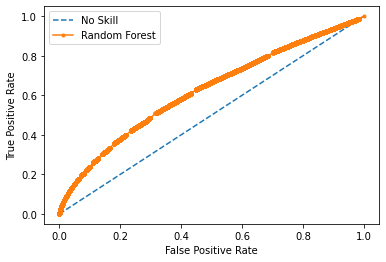

In [ ]:

ns_probs = [0 for _ in range(len(Y_test))]
lr_probs = Rforest_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(Y_test, ns_probs)
lr_auc = roc_auc_score(Y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [40]:
from IPython.display import clear_output

for i in range(10):
    clear_output(wait=True)
    print("Hello World!")

Hello World!
